# CLIPText Implementation

This notebook implements CLIPText from the paper "CLIPTEXT: A New Paradigm for Zero-shot Text Classification"

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import clip
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1. Load Pre-trained CLIP Model

We'll use the pre-trained CLIP model from Hugging Face

In [2]:
# Load CLIP model and processor
model, preprocess = clip.load("ViT-B/32", device=device)

## 2. Text Classification Dataset

Let's implement a dataset class for text classification

In [3]:
class TextClassificationDataset(Dataset):
    """
    文本分类数据集类
    Args:
        texts: 文本列表
        labels: 标签列表
        transform: 文本转换函数(如prompt模板)
    """
    def __init__(self, texts, labels, transform=None):
        self.texts = texts
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        if self.transform:
            text = self.transform(text)
            
        return text, label

## 3. Label-to-Image Mapping

Function to map text labels to corresponding images

In [4]:
def load_image_from_url(url):
    """
    从URL加载图片
    Args:
        url: 图片URL
    Returns:
        PIL Image对象
    """
    try:
        response = requests.get(url)
        img = Image.open(BytesIO(response.content))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        return img
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return Image.new('RGB', (224, 224), 'black')

def get_label_images(label_list):
    """
    为标签获取对应的图片
    Args:
        label_list: 标签列表
    Returns:
        dict: 标签到图片的映射
    """
    label_to_image = {}
    
    # 为每个标签定义对应的图片URL
    image_urls = {
        # 这里使用更有代表性的图片URL
        "sports": "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png",
        "business": "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png", 
        "world": "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png",
        "sci/tech": "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png"
    }
    
    for label in label_list:
        img_url = image_urls.get(label, "https://raw.githubusercontent.com/openai/CLIP/main/CLIP.png")
        label_to_image[label] = load_image_from_url(img_url)
    return label_to_image

## 4. CLIPText Model

Implement the CLIPText model for zero-shot text classification

In [5]:
class CLIPText:
    """
    CLIPText模型类
    使用CLIP进行零样本文本分类
    """
    def __init__(self, model, preprocess, label_images):
        self.model = model
        self.preprocess = preprocess
        self.label_images = label_images
        
    def predict(self, texts, return_probs=False):
        """
        预测文本类别
        Args:
            texts: 文本或文本列表
            return_probs: 是否返回概率
        Returns:
            预测标签和概率(如果return_probs=True)
        """
        if isinstance(texts, str):
            texts = [texts]
            
        # 文本编码
        text_tokens = clip.tokenize(texts).to(device)
        
        # 图片预处理
        images = []
        for img in self.label_images.values():
            processed_img = self.preprocess(img).unsqueeze(0).to(device)
            images.append(processed_img)
        image_input = torch.cat(images)
        
        # 获取特征和预测
        with torch.no_grad():
            text_features = self.model.encode_text(text_tokens)
            image_features = self.model.encode_image(image_input)
            
            # 特征归一化
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            
            # 计算相似度
            similarity = torch.matmul(text_features, image_features.t())
            
            # Softmax获取概率
            probs = F.softmax(similarity * 100.0, dim=-1)
            
            # 获取预测
            predictions = similarity.argmax(dim=-1)
        
        # 转换为标签
        label_list = list(self.label_images.keys())
        predicted_labels = [label_list[i] for i in predictions.cpu().numpy()]
        
        if return_probs:
            return predicted_labels, probs.cpu().numpy()
        return predicted_labels[0] if len(texts) == 1 else predicted_labels


## 5. Prompt Engineering

Add prompt templates for different classification tasks

In [6]:
class PromptTemplate:
    """
    Prompt模板类
    为不同任务添加特定的prompt
    """
    def __init__(self, task_type):
        self.prompts = {
            'topic': 'This text is about {}',
            'emotion': 'The emotion in this text is {}',
            'situation': 'This describes a situation of {}',
            'intent': 'The intent of this text is {}',
            'news': 'This is a {} news article',
            'opinion': 'This expresses {} opinion',
            'question': 'This is a {} type question'
        }
        self.task_type = task_type
        
    def apply(self, text):
        template = self.prompts.get(self.task_type, '{}')
        return template.format(text)

## 6. Evaluation

Functions to evaluate the model performance

In [7]:
def evaluate(model, dataset, batch_size=32):
    """
    评估模型性能
    Args:
        model: CLIPText模型
        dataset: 数据集
        batch_size: 批次大小
    Returns:
        accuracy: 准确率
        predictions: 预测结果
        true_labels: 真实标签
    """
    dataloader = DataLoader(dataset, batch_size=batch_size)
    predictions = []
    true_labels = []
    
    for texts, labels in dataloader:
        batch_preds = model.predict(texts)
        predictions.extend(batch_preds)
        true_labels.extend(labels)
        
    correct = sum(p == l for p, l in zip(predictions, true_labels))
    accuracy = correct / len(true_labels) * 100
    
    return accuracy, predictions, true_labels

In [8]:
def plot_confusion_matrix(true_labels, predictions, labels):
    """
    绘制混淆矩阵
    """
    cm = confusion_matrix(true_labels, predictions, labels=labels)
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

## 7. Example Usage

Demonstrate how to use CLIPText for zero-shot text classification


Predictions:
Text: This is a Manchester United wins against Liverpool in dramatic match news article
Predicted: sci/tech, True: sports

Text: This is a Apple announces record profits in Q4 earnings report news article
Predicted: sci/tech, True: business

Text: This is a NASA discovers new exoplanet in habitable zone news article
Predicted: sci/tech, True: sci/tech

Text: This is a Global markets react to economic policy changes news article
Predicted: sci/tech, True: business

Overall Accuracy: 25.00%

Classification Report:
              precision    recall  f1-score   support

    business       0.00      0.00      0.00         2
    sci/tech       0.25      1.00      0.40         1
      sports       0.00      0.00      0.00         1

    accuracy                           0.25         4
   macro avg       0.08      0.33      0.13         4
weighted avg       0.06      0.25      0.10         4



/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


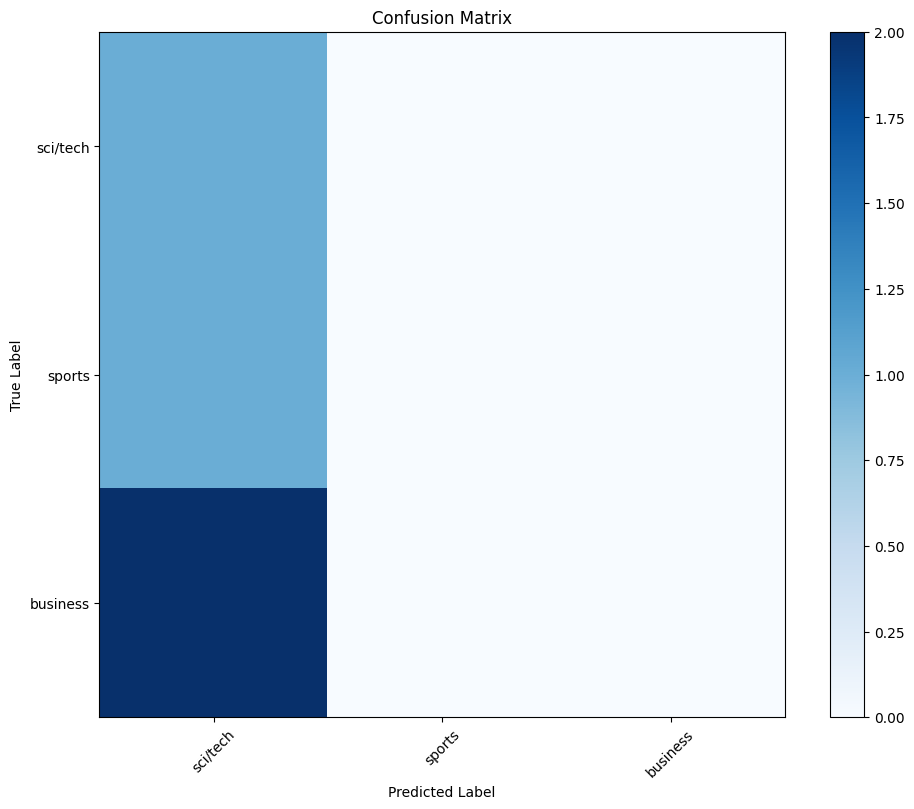

In [9]:
if __name__ == "__main__":
    # 加载AG News数据集示例
    texts = [
        "Manchester United wins against Liverpool in dramatic match",
        "Apple announces record profits in Q4 earnings report",
        "NASA discovers new exoplanet in habitable zone",
        "Global markets react to economic policy changes"
    ]
    labels = ["sports", "business", "sci/tech", "business"]
    
    # 创建数据集
    dataset = TextClassificationDataset(texts, labels)
    
    # 获取标签图片
    unique_labels = set(labels)
    label_images = get_label_images(unique_labels)
    
    # 创建CLIPText模型
    cliptext = CLIPText(model, preprocess, label_images)
    
    # 添加prompt
    prompt_template = PromptTemplate('news')
    texts = [prompt_template.apply(t) for t in texts]
    
    # 预测并评估
    predictions, probs = cliptext.predict(texts, return_probs=True)
    print("\nPredictions:")
    for text, pred, true_label in zip(texts, predictions, labels):
        print(f"Text: {text}\nPredicted: {pred}, True: {true_label}\n")
    
    # 评估性能
    accuracy, all_preds, true_labels = evaluate(cliptext, dataset)
    print(f"Overall Accuracy: {accuracy:.2f}%")
    
    # 打印详细分类报告
    print("\nClassification Report:")
    print(classification_report(true_labels, all_preds))
    
    # 绘制混淆矩阵
    plot_confusion_matrix(true_labels, all_preds, list(unique_labels))